# Multiway spectral community detection in neworks

#### Written by Carlo Fisicaro 

In [1]:
%pylab inline
import pandas as pd
import networkx as nx
import igraph as ig
import community
from scipy import linalg
import copy

Populating the interactive namespace from numpy and matplotlib


This is a python2 implementation of a vector partitioning algorithm, presented by M.E.J Newman and Xiao Zhang in the paper "Multiway Spectral Community Detection 2015" works. You can use it to detect non overlapping communities in both undirected and directed graphs, weighted or unweighted.

In [2]:
#import network
G = nx.read_gml('netscience.gml', relabel=True)

In [22]:
#create modularity matrix
a = nx.adjacency_matrix(G, weight='value')
A = a.todense()

n = len(A)  # number of vertices
if allclose(A, A.T, atol=1e-8) == True:   #check if A is symmetric
    
    # undirected modularity matrix
    k = np.sum(A, axis=0)  # degrees
    two_m = np.sum(k)  # 2*number of edges
    B = A - true_divide(outer(k, k), two_m)
    
else:
    
    # directed modularity matrix
    ki = np.sum(A, axis=0)  # in degree
    ko = np.sum(A, axis=1)  # out degree
    m = np.sum(ki)  # number of edges
    b = A - true_divide(outer(ko, ki), m)
    B = b + b.T

In [23]:
#vertex vectors
eig_val_B, U = linalg.eigh(B)  # the i-th column is the i-th eigenvector which corresponds to the i-th eigenvalue

#take only the eigenvalues > 0
eig_pos_position = [list(eig_val_B).index(x) for x in eig_val_B if x>0]
eig_val_B_pos = []
u_pos = []
for position in eig_pos_position:
    eig_val_B_pos.append(eig_val_B[position])
    u_pos.append(U[:, position])
    
U_pos = array(u_pos).T

In [24]:
len(eig_val_B_pos)

628

In [38]:
#take only the main eigenvalues
from heapq import nlargest

nleading_eig_vectors = 627  
nbigger_eig_val_B = nlargest(nleading_eig_vectors, eig_val_B_pos)
eig_bigger_position = [list(eig_val_B_pos).index(x) for x in eig_val_B_pos if x in nbigger_eig_val_B]

eig_val_B_lead = []  #leading eigen values
u_lead = []  #leading eigen vectors

for position in eig_bigger_position:
    eig_val_B_lead.append(eig_val_B_pos[position])
    u_lead.append(U_pos[:, position])
    
U_lead = array(u_lead).T

p = len(eig_val_B_lead)  
r=U_lead*sqrt(eig_val_B_lead)

vertex_vectors = {}

for i in range(n):
    vertex_vectors[G.nodes()[i]] = list(r[i])

In [39]:
#random group vectors initialization
import random 

n_clusters = 50
rand_group_vectors = {}
rand_clusters = {}

#fix k-1 group vectors
for i in range(n_clusters-1): 
    rand_key = random.choice(vertex_vectors.keys())
    rand_group_vectors[i] = vertex_vectors.get(rand_key)
    rand_clusters[i] = []

#fix the k-th group vector
rand_group_vectors[n_clusters-1] = [i * (-1) for i in sum(rand_group_vectors.values(), axis = 0).tolist()]
rand_clusters[n_clusters-1] = []
    
#random clusters initialization

for node in G.nodes():
    vertex_group_prod = {}
    for i in range(n_clusters):
        vertex_group_prod[i] = []
        vertex_group_prod[i].append(inner(vertex_vectors[node], rand_group_vectors[i]).tolist())
    max_prod = max(vertex_group_prod.values())
    max_prod_key = vertex_group_prod.keys()[vertex_group_prod.values().index(max_prod)]
    rand_clusters[max_prod_key].append(node)
        

update_group_vectors = []
update_clusters = []
update_clusters.append(rand_clusters)
update_group_vectors.append(rand_group_vectors)

In [40]:
def vector_partitioning(vertex_vectors, G): #update the group vectors and the clusters
    
    #group vectors
    new_group_vectors = {}
    clusters = update_clusters[-1]

    for i in range(n_clusters):
        components = []
        new_group_vectors[i] = []
        n_cluster_elements = len(clusters[i])
        
        if n_cluster_elements > 0:
            for j in range(n_cluster_elements):
                components.append(vertex_vectors[clusters[i][j]]) #vertex_vector del nodo j che stà nel clustrer i
        else:
            components.append(list(zeros(p)))

        new_group_vectors[i] = sum(components, axis = 0).tolist()
      
    #clusters
    old_clusters = update_clusters[-1]
    new_clusters = copy.deepcopy(old_clusters)
    
    for node in G.nodes():
        vertex_group_prod = {}
        cluster = sum([k for k, v in old_clusters.iteritems() if node in v]) #cluster cui appartiene node
        
        for i in range(n_clusters):
            vertex_group_prod[i] = []
            
            if i == cluster:
                vertex_vector_in_cluster = subtract(new_group_vectors[i], vertex_vectors[node])
                vertex_group_prod[i].append(inner(vertex_vector_in_cluster, vertex_vectors[node]).tolist()) 
            else:
                vertex_group_prod[i].append(inner(new_group_vectors[i], vertex_vectors[node]).tolist())
                
        max_prod = max(vertex_group_prod.values())
        max_prod_key = vertex_group_prod.keys()[vertex_group_prod.values().index(max_prod)]
        if max_prod_key != cluster:
            new_clusters[max_prod_key].append(node)
            new_clusters[cluster].remove(node)
            
    #update
    update_group_vectors.append(new_group_vectors)
    update_clusters.append(new_clusters)

In [41]:
modularities = []

#here you can update the group vector until they stop changing
#while update_group_vectors[-1] != update_group_vectors[-2]:

#or you can fix the number of steps
steps = 10
x = 0
while x < steps:
    vector_partitioning(vertex_vectors, G)
    communities_final = update_clusters[-1]
    partition_l = {}
    for i in range(len(communities_final.values())):
        for j in range(len(communities_final.values()[i])):
            partition_l[communities_final.values()[i][j]]=communities_final.keys()[i]
    modu = community.modularity(partition_l, G.to_undirected())
    modularities.append(modu)
    x += 1

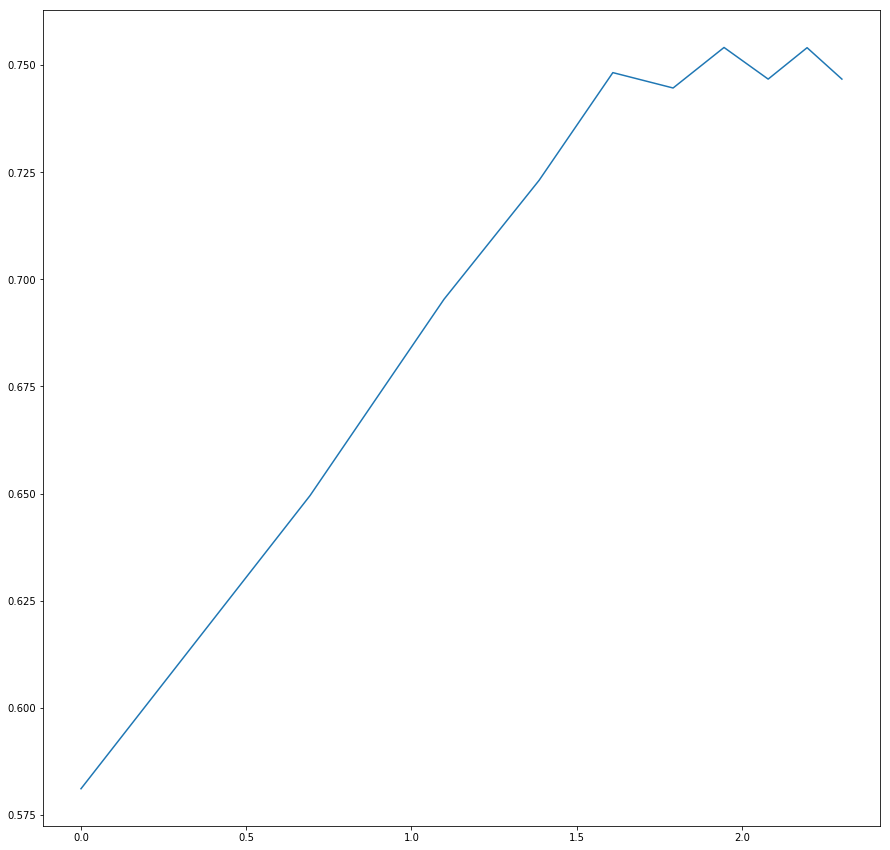

In [42]:
plot(log(xrange(1,steps+1)), modularities)

In [43]:
#best partition
max_mod_position = [list(modularities).index(x) for x in modularities if x == max(modularities)]
communities_final = update_clusters[max_mod_position[0]-1]

partition_final = {}
for i in range(len(communities_final.values())):
    for j in range(len(communities_final.values()[i])):
        partition_final[communities_final.values()[i][j]]=communities_final.keys()[i]
        
final_mod = community.modularity(partition_final, G.to_undirected())
size = float(len(set(partition_final.values())))
print 'The number of communities in the network is:', size
print 'The modularity score is:', final_mod

The number of communities in the network is: 35.0
The modularity score is: 0.748237562386


The number of communities in the network is: 35.0
The modularity score is: 0.748237562386


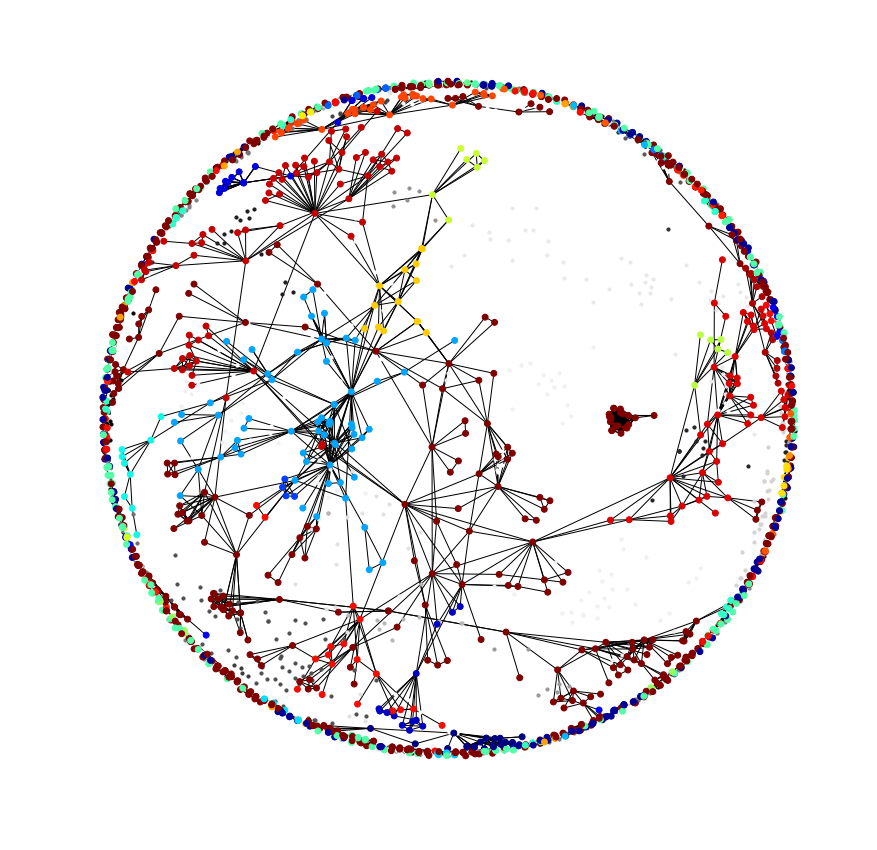

In [45]:
def draw_communities_vector_partitioning(G, partition):        
    size = float(len(set(partition.values())))

    pos = nx.spring_layout(G)
    figure(figsize(15,15))
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 10, node_color = str(count / size))
        
    colors = [partition.get(node) for node in G.nodes()]
    mypos = nx.spring_layout(G)
    axis('off')
    
    nx.draw_networkx(G, pos=mypos, cmap=plt.get_cmap('jet'), node_color=colors, node_size=35, with_labels=False)
    print 'The number of communities in the network is:', size
    print 'The modularity score is:', community.modularity(partition, G.to_undirected())
    
draw_communities_vector_partitioning(G, partition_final)

In [46]:
communities_final

{0: [u'DARROW, W',
  u'MUTH, S',
  u'MUTH, J',
  u'ROTHENBERG, R',
  u'KLOVDAHL, A',
  u'POTTERAT, J',
  u'WOODHOUSE, D',
  u'PHILLIPSPLUMMER, L',
  u'ZIMMERMAN, H',
  u'MALDONADOLONG, T',
  u'WHITE, H',
  u'TROTTER, R',
  u'GREEN, D',
  u'BALDWIN, J',
  u'TAYLOR, J',
  u'BONNEY, M',
  u'ZIMMERMANROGER, H',
  u'LORRAIN, F',
  u'WELLMAN, B',
  u'NAZER, N',
  u'BREIGER, R',
  u'BOORMAN, S',
  u'ARABIE, P'],
 1: [u'SELKOVJR, E',
  u'STRAUGHN, B',
  u'EGUIA, M',
  u'NETTLE, D',
  u'QUILICHINI, P',
  u'LARSEN, N',
  u'CRANE, D',
  u'PAPADIMITRIOU, C',
  u'GOLDWASSER, L',
  u'FABRIKANT, A',
  u'JACOBSON, V',
  u'ZENG, A',
  u'KARIMIPOUR, V',
  u'ANDERSON, P',
  u'HE, M',
  u'DOOB, M',
  u'VOGELS, W',
  u'CASSI, D',
  u'POTHEN, A',
  u'STRAUSS, D',
  u'MASHAGHI, A',
  u'FONSTEIN, M',
  u'ARROW, K',
  u'VANRENESSE, R',
  u'MANN, M',
  u'SELKOV, E',
  u'SCHONFISCH, B',
  u'RAFF, M',
  u'ANDERSSON, H',
  u'BAHIANA, M',
  u'PUSCH, G',
  u'HARARY, F',
  u'DURAND, D',
  u'STONEHAM, A',
  u'MASOLLER